In [192]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import numpy as np

In [193]:
def notify(title, text, model):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))
    # os.system(f'say "{model.__class__.__name__} training complete!"')

In [194]:
rawWhitesDF = pd.read_csv("raw-wine-data/winequality-white.csv", delimiter=";")
rawRedsDF = pd.read_csv("raw-wine-data/winequality-red.csv", delimiter=";")

In [195]:
rawWhitesDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [196]:
featureLabels = list(rawWhitesDF.columns.values)
classes = [c for c in range(1, 11)]

# Normalising the continuous data with MinMax scaling
scaledWhitesDF = rawWhitesDF.copy()
scaledRedsDF = rawRedsDF.copy()

for column in featureLabels[:-1]:
    scaledWhitesDF[column] = (scaledWhitesDF[column] - scaledWhitesDF[column].min()) / (scaledWhitesDF[column].max() - scaledWhitesDF[column].min())
    scaledRedsDF[column] = (scaledRedsDF[column] - scaledRedsDF[column].min()) / (scaledRedsDF[column].max() - scaledRedsDF[column].min())

In [197]:
whiteTargetsInt = torch.tensor(scaledWhitesDF['quality'].to_numpy())
whiteFeatures = torch.tensor(scaledWhitesDF[featureLabels[0:-1]].to_numpy(), requires_grad=True, dtype=torch.float32)

redTargetsInt = torch.tensor(scaledRedsDF['quality'].to_numpy())
redFeatures = torch.tensor(scaledRedsDF[featureLabels[0:-1]].to_numpy(), requires_grad=True, dtype=torch.float32)

In [198]:
whiteTargets =  []

for i, target in enumerate(whiteTargetsInt):
    embed = torch.zeros(len(classes), dtype=torch.float32)
    embed[target.item()-1] = 1
    whiteTargets.append(embed)
whiteTargets = torch.stack(whiteTargets).to(torch.float32)

redTargets = []

for i, target in enumerate(redTargetsInt):
    embed = torch.zeros(len(classes), dtype=torch.float32)
    embed[target.item()-1] = 1
    redTargets.append(embed)
redTargets = torch.stack(redTargets).to(torch.float32)

In [199]:
class WineDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = {
            'features': self.features[idx],
            'target': self.targets[idx]
        }
        return sample

In [200]:
train_indices, test_indices = train_test_split(range(len(whiteFeatures)), test_size=0.2, random_state=22)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1, random_state=22)

In [201]:
train_dataset = WineDataset(whiteFeatures[train_indices], whiteTargets[train_indices])
val_dataset = WineDataset(whiteFeatures[val_indices], whiteTargets[val_indices])
test_dataset = WineDataset(whiteFeatures[test_indices], whiteTargets[test_indices])

batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

red_test_dataset = WineDataset(redFeatures, redTargets)
red_test_loader = DataLoader(dataset=red_test_dataset, batch_size=batch_size, shuffle=False)

In [202]:
class FeedForwardModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class ConvModel(nn.Module):
    def __init__(self, input_channels, output_size, hidden_size):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)
        # Convolutional layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # Flatten
        x = x.reshape(x.shape[0], -1)
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_heads, hidden_size, dropout):
        super(TransformerModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Linear(input_size, hidden_size)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # Output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply embedding
        x = self.embedding(x)
        
        x = x.unsqueeze(1) # (batch_size, seq_len, hidden_size)
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)

        x = x.squeeze(1) # (batch_size, hidden_size)
        
        # Apply output layer
        x = self.relu(self.output_layer(x))

        return x

In [203]:
def train(model, device, train_loader, optimiser, nepoch, scheduler_step_size, scheduler_gamma):
    scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=scheduler_step_size, gamma=scheduler_gamma)
    model.to(device)
    
    train_losses, val_losses = [], []

    model.train()
    
    # for epoch in range(nepoch):
    for epoch in tqdm(range(nepoch), leave=False, unit='epoch', desc= "Epochs"):
        
        total_train_loss = 0
        train_count = 0
        total_val_loss = 0
        val_count = 0
        
        for batch in train_loader:
            inputs, targets = batch['features'], batch['target']
            inputs, targets = inputs.to(device).detach(), targets.to(device).detach()
            
            optimiser.zero_grad()
            outputs = model(inputs)
            
            train_loss = criterion(outputs, targets)
            train_loss.backward()
            optimiser.step()
            
            total_train_loss += train_loss.item()
            train_count += 1
        
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch['features'], batch['target']
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                
                val_loss = criterion(outputs, targets)
                
                total_val_loss += val_loss.item()
                val_count += 1
        
        train_losses.append(total_train_loss/train_count)
        val_losses.append(total_val_loss/val_count)
        scheduler.step()
    
    plt.semilogy(train_losses)
    plt.semilogy(val_losses)
    plt.legend(["Train loss", "Val. loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    notify("Training Finished", "", model)
    # print("Final training loss:  ", round(train_losses[-1], 4))
    # print("Final validation loss:", round(val_losses[-1], 4))

def test(model, device, test_loader):
    model.to(device)
    
    correct, total = 0, 0
    model.eval()
    
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch['features'], batch['target']
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            
            # predicted = torch.argmax(outputs, dim=1)
            predicted = torch.topk(outputs, 2, dim=1).indices
            actual = torch.argmax(targets, dim=1)
            
            total += targets.size(0)
            correct += torch.sum(torch.any(predicted.eq(actual.unsqueeze(1)), dim=1)).item() # ChatGPT output. Include in write-up.
            
    acc = round(100 * correct / total, 4)
    return acc

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

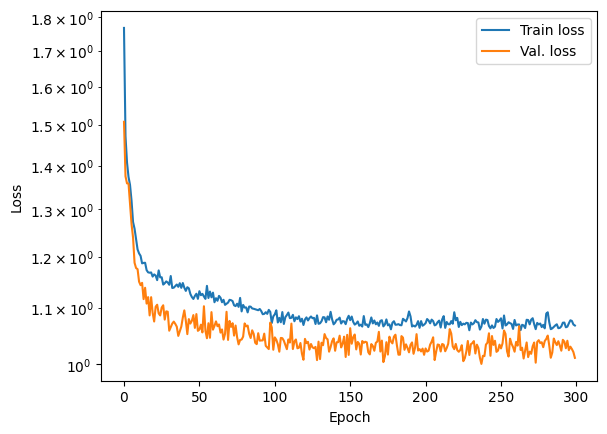

In [204]:
baseModel = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=6, num_heads=16, hidden_size=128, dropout=0.5)
criterion = nn.CrossEntropyLoss()
baseOptimiser = torch.optim.Adam(baseModel.parameters(), lr=1e-4, weight_decay=1e-5)

device = torch.device("cpu")
# device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

scheduler_step_size = 100
scheduler_gamma = 0.1
nepoch = 300

train(baseModel, device, train_loader, baseOptimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [205]:
# Testing the base model on withheld white wine data.
white_base_acc = test(baseModel, device, test_loader)
print("Base model top-2 accuracy on white wine dataset:", white_base_acc)

Base model top-2 accuracy on white wine dataset: 86.0204


In [206]:
# Printing model summary
import torchinfo
print(torchinfo.summary(baseModel, (64, 11), col_names = ("input_size", "output_size", "num_params")))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
TransformerModel                              [64, 11]                  [64, 10]                  --
├─Linear: 1-1                                 [64, 11]                  [64, 128]                 1,536
├─TransformerEncoder: 1-2                     [64, 1, 128]              [64, 1, 128]              --
│    └─ModuleList: 2-1                        --                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 1, 128]              [64, 1, 128]              99,584
│    │    └─TransformerEncoderLayer: 3-2      [64, 1, 128]              [64, 1, 128]              99,584
│    │    └─TransformerEncoderLayer: 3-3      [64, 1, 128]              [64, 1, 128]              99,584
│    │    └─TransformerEncoderLayer: 3-4      [64, 1, 128]              [64, 1, 128]              99,584
│    │    └─TransformerEncoderLayer: 3-5      [64, 1, 128]         

Computational Experiment 1: Testing base model generalisability on red wine dataset.

In [207]:
# Testing the model on red wine data.
red_base_acc = test(baseModel, device, red_test_loader)
print("Base model top-2 accuracy on red wine dataset:", red_base_acc)

Base model top-2 accuracy on red wine dataset: 75.3596


Computational Experiment 2: Comparing performance of transformer, feed-forward and CNN.

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

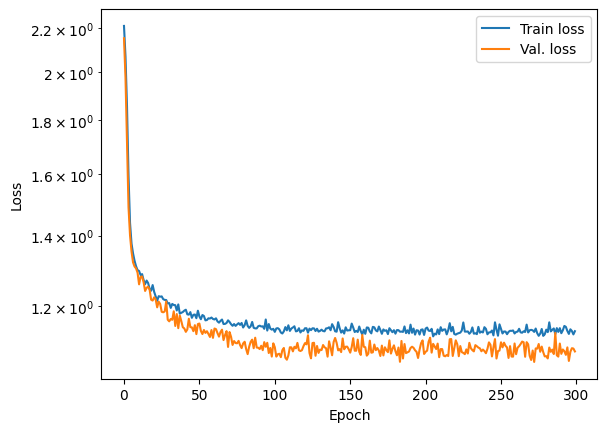

In [208]:
FFModel = FeedForwardModel(input_size=whiteFeatures.shape[1], output_size=len(classes),hidden_size=128)
FFOptimiser = torch.optim.Adam(FFModel.parameters(), lr=1e-4, weight_decay=1e-5)

train(FFModel, device, train_loader, FFOptimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [209]:
# Testing the feed-forward model on withheld white wine data.
white_FF_acc = test(FFModel, device, test_loader)
print("Feed-forward model top-2 accuracy on white wine dataset:", white_FF_acc) # 

Feed-forward model top-2 accuracy on white wine dataset: 83.5714


Pretty similar. Makes sense since Transformers are best at sequential because of the multi-head attention. Might not even be worth using transformers because of the much longer training time.  \
    - ~6 mins to train transformer \
    - 

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

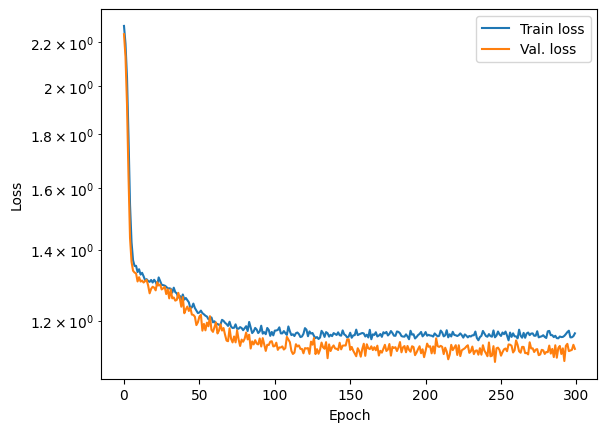

In [210]:
CNNModel = ConvModel(input_channels=1, output_size=len(classes), hidden_size=128)
CNNOptimiser = torch.optim.Adam(CNNModel.parameters(), lr=1e-4, weight_decay=1e-5)

train(CNNModel, device, train_loader, CNNOptimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [211]:
# Testing the CNN model on withheld white wine data.
white_CNN_acc = test(CNNModel, device, test_loader)
print("CNN model top-2 accuracy on white wine dataset:", white_CNN_acc) # 

CNN model top-2 accuracy on white wine dataset: 83.5714


You could call the three all even since I spent the most time toying with the transformer model hyperparameters trying to get it optimal. Not how well each of them works, its how well they work in unison.

Computational Experiment 3: 

Dropout at 35%

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

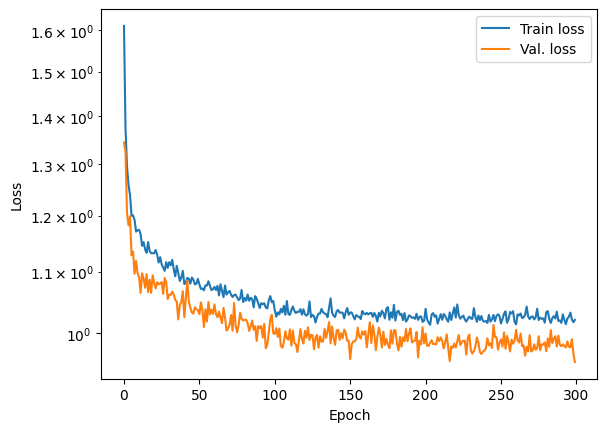

In [212]:
drop35Model = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=6, num_heads=16, hidden_size=128, dropout=0.35)
drop35Optimiser = torch.optim.Adam(drop35Model.parameters(), lr=1e-4, weight_decay=1e-5)
train(drop35Model, device, train_loader, drop35Optimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [213]:
# Testing the dropout-20% model on withheld white wine data.
white_drop35_acc = test(drop35Model, device, test_loader)
print("Dropout-35% model top-2 accuracy on white wine dataset:", white_drop35_acc)

Dropout-35% model top-2 accuracy on white wine dataset: 86.4286


Testing dropout at 20%.

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

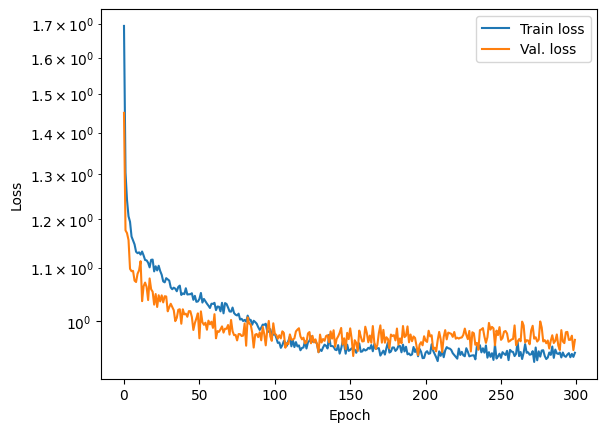

In [214]:
drop20Model = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=6, num_heads=16, hidden_size=128, dropout=0.2)
drop20Optimiser = torch.optim.Adam(drop20Model.parameters(), lr=1e-4, weight_decay=1e-5)
train(drop20Model, device, train_loader, drop20Optimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [215]:
# Testing the dropout-20% model on withheld white wine data.
white_drop20_acc = test(drop20Model, device, test_loader)
print("Dropout-20% model top-2 accuracy on white wine dataset:", white_drop20_acc)

Dropout-20% model top-2 accuracy on white wine dataset: 86.9388


Variations in number of layers

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

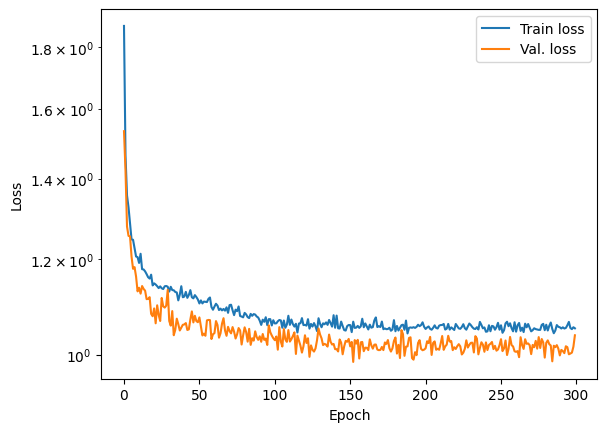

In [216]:
hidden3Model = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=3, num_heads=16, hidden_size=128, dropout=0.5)
hidden3Optimiser = torch.optim.Adam(hidden3Model.parameters(), lr=1e-4, weight_decay=1e-5)
train(hidden3Model, device, train_loader, hidden3Optimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [217]:
# Testing the hidden-4 model on withheld white wine data.
white_hidden3_acc = test(hidden3Model, device, test_loader)
print("Hidden-3 model top-2 accuracy on white wine dataset:", white_hidden3_acc)

Hidden-3 model top-2 accuracy on white wine dataset: 86.6327


4 hidden layers

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

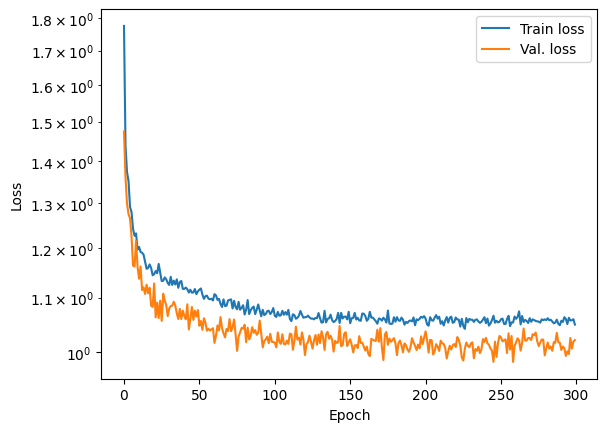

In [218]:
hidden4Model = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=4, num_heads=16, hidden_size=128, dropout=0.5)
hidden4Optimiser = torch.optim.Adam(hidden4Model.parameters(), lr=1e-4, weight_decay=1e-5)
train(hidden4Model, device, train_loader, hidden4Optimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [219]:
# Testing the hidden-4 model on withheld white wine data.
white_hidden4_acc = test(hidden4Model, device, test_loader)
print("Hidden-4 model top-2 accuracy on white wine dataset:", white_hidden4_acc)

Hidden-4 model top-2 accuracy on white wine dataset: 86.2245


5 hidden layers

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

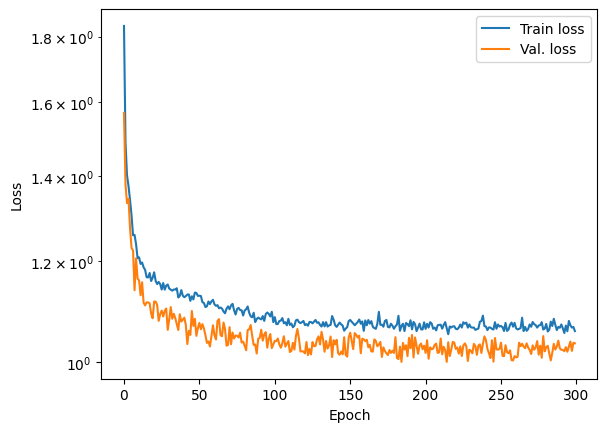

In [220]:
hidden5Model = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=5, num_heads=16, hidden_size=128, dropout=0.5)
hidden5Optimiser = torch.optim.Adam(hidden5Model.parameters(), lr=1e-4, weight_decay=1e-5)
train(hidden5Model, device, train_loader, hidden5Optimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [221]:
# Testing the hidden-5 model on withheld white wine data.
white_hidden5_acc = test(hidden5Model, device, test_loader)
print("Hidden-5 model top-2 accuracy on white wine dataset:", white_hidden5_acc)

Hidden-5 model top-2 accuracy on white wine dataset: 86.6327


6 hidden layers

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

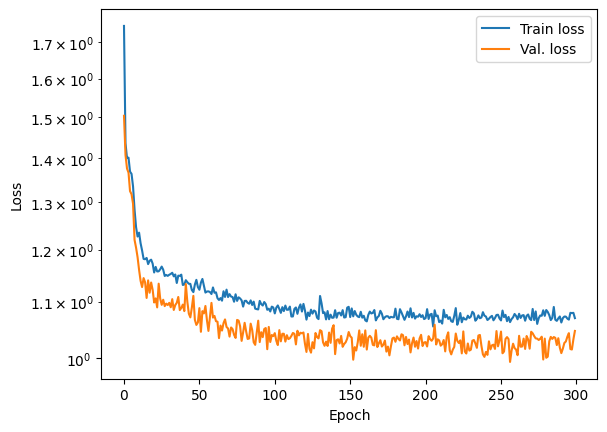

In [222]:
hidden6Model = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=6, num_heads=16, hidden_size=128, dropout=0.5)
hidden6Optimiser = torch.optim.Adam(hidden6Model.parameters(), lr=1e-4, weight_decay=1e-5)
train(hidden6Model, device, train_loader, hidden6Optimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [223]:
# Testing the hidden-5 model on withheld white wine data.
white_hidden6_acc = test(hidden6Model, device, test_loader)
print("Hidden-6 model top-2 accuracy on white wine dataset:", white_hidden6_acc)

Hidden-6 model top-2 accuracy on white wine dataset: 86.0204


7 hidden layers

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

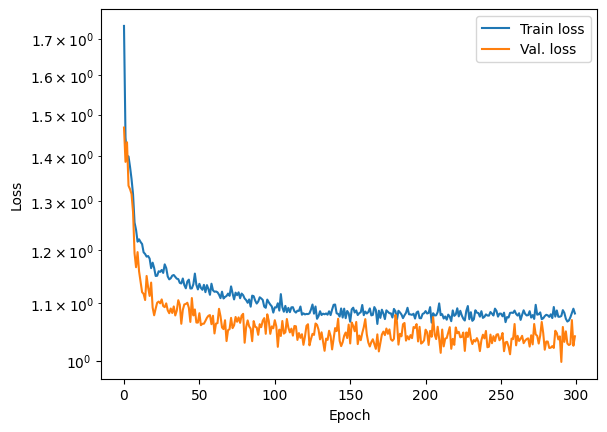

In [224]:
hidden7Model = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=7, num_heads=16, hidden_size=128, dropout=0.5)
hidden7Optimiser = torch.optim.Adam(hidden7Model.parameters(), lr=1e-4, weight_decay=1e-5)
train(hidden7Model, device, train_loader, hidden7Optimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [225]:
# Testing the hidden-5 model on withheld white wine data.
white_hidden7_acc = test(hidden7Model, device, test_loader)
print("Hidden-7 model top-2 accuracy on white wine dataset:", white_hidden7_acc)

Hidden-7 model top-2 accuracy on white wine dataset: 86.0204


8 hidden layers

Epochs:   0%|          | 0/300 [00:00<?, ?epoch/s]

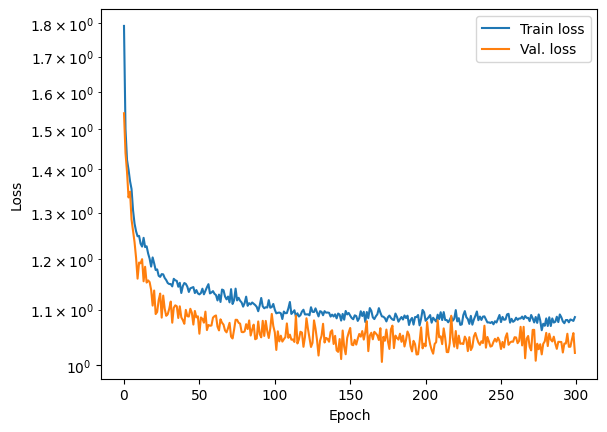

In [226]:
hidden8Model = TransformerModel(input_size=whiteFeatures.shape[1], output_size=len(classes), num_layers=8, num_heads=16, hidden_size=128, dropout=0.5)
hidden8Optimiser = torch.optim.Adam(hidden8Model.parameters(), lr=1e-4, weight_decay=1e-5)
train(hidden8Model, device, train_loader, hidden8Optimiser, nepoch, scheduler_step_size, scheduler_gamma)

In [227]:
# Testing the hidden-5 model on withheld white wine data.
white_hidden8_acc = test(hidden8Model, device, test_loader)
print("Hidden-8 model top-2 accuracy on white wine dataset:", white_hidden8_acc)

Hidden-8 model top-2 accuracy on white wine dataset: 85.4082
